SER

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile
import librosa.display
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, GRU, LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import seaborn as sns
import IPython.display as ipd

import torch
import torch.utils.data as tdata

import ffmpeg

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [22]:
path1 = r"D:\Program Files\VS Code Projects\elec-301-speech-emotion-classification\data"
os.chdir(path1)

Visulization

In [ ]:
# Visualizing wave forms - test
filename = os.listdir()
file = 'fearful022.wav'
samplerate, data = wavfile.read(file)
data = data.astype(float)
plt.figure(figsize=(15,5))
plt.title('Waveplot for ' + file)
librosa.display.waveshow(data,sr=samplerate)

X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 3))
plt.title('Spectrogram for ' + file)
librosa.display.specshow(Xdb, sr=samplerate, x_axis='time', y_axis='hz') 
plt.colorbar()
ipd.Audio(file)

Creating Raw Dataframe

In [23]:
path = r"D:\Program Files\VS Code Projects\elec-301-speech-emotion-classification\data"
os.chdir(path)

file_emotion = []
file_path = []
for file in os.listdir():
    file_path.append(file)
    file_emotion.append(file[: -7])

emotion_df = pd.DataFrame(file_emotion,columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)
data_path.head()

,Emotions,Path
0,angry,angry000.wav
1,angry,angry001.wav
2,angry,angry002.wav
3,angry,angry003.wav
4,angry,angry004.wav


In [24]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [25]:
def extract_features(data, sample_rate):
    # # ZCR
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    # result=np.hstack((result, zcr)) # stacking horizontally

    # # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    # chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)

    # # Root Mean Square Value
    # rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    # result = np.hstack((result, rms)) # stacking horizontally

    # # MelSpectogram
    # mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, mel)) # stacking horizontally
    
    return mfcc

def get_features(path, mode):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, 48000)
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = []
    result.append(np.array(res1))
    
    # data with noise
    if mode == "train":
        noise_data = noise(data)
        res2 = extract_features(noise_data, sample_rate)
    
        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch, sample_rate)
    
        result.append(np.array(res2))
        result.append(np.array(res3))
        return result
    else:
        return result

def pad_result(data, max_length):
    (_, windows) = data.shape
    signal = np.ndarray.flatten(data)
    (signal_length,) = signal.shape
    signal = np.pad(signal, (0,max_length-signal_length), 'constant', constant_values = (0,0))
    
    return signal

In [26]:
X = []
Y = []
max_val = 618
for path, emotion in zip(data_path.Path, data_path.Emotions):
    if path.endswith(".wav"):
        feature = get_features(path, "train")
        for signal in feature:
            X.append(signal)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)

In [27]:
# Zero padding the signal
for i in range(len(X)):
    data = X[i]
    X[i] = pad_result(data,max_val*20)

In [28]:
len(X), len(Y)

(3375, 3375)

In [29]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,12351,12352,12353,12354,12355,12356,12357,12358,12359,labels
0,-538.932373,-533.698059,-532.217285,-531.713623,-532.007385,-529.898804,-530.397217,-531.561646,-531.122437,-531.508972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,-274.102222,-239.994990,-238.969568,-237.162420,-235.410433,-240.549204,-239.020419,-238.523861,-241.423420,-240.779211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,-558.416687,-551.203430,-554.391418,-555.437195,-556.074402,-558.526794,-558.818481,-558.159729,-557.531738,-556.670044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,-617.034058,-617.034058,-617.034058,-617.034058,-617.034058,-617.034058,-617.034058,-617.034058,-617.034058,-617.034058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
4,-286.583852,-253.552394,-248.635295,-252.046453,-251.390555,-250.571125,-258.703612,-256.351089,-251.514433,-250.024237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry


Data Preparation

In [30]:
path = r"D:\Program Files\VS Code Projects\elec-301-speech-emotion-classification\data"
os.chdir(path)

# Features = pd.read_csv('features.csv')
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# Features = pd.read_csv('mfcc_mean_caca.csv')
# X = Features.iloc[:, 1:].values
# Y = Features['emotion'].values

Z = []
for emo in range(0, len(Y)):
    if Y[emo] == 'angry':
      Z.append(0)
    if Y[emo] == 'calm':
      Z.append(1)
    if Y[emo] == 'disgust':
      Z.append(2)
    if Y[emo] == 'fearful':
      Z.append(3)
    if Y[emo] == 'happy':
      Z.append(4)
    if Y[emo] == 'neutral':
      Z.append(5)
    if Y[emo] == 'sad':
      Z.append(6)
    if Y[emo] == 'surprised':
      Z.append(7)

Y = np.array(Z)

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2, shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((2700, 12360), (2700,), (675, 12360), (675,))

MLP Classifier

In [31]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Simple NN with three hidden layers
        self.fc1 = torch.nn.Linear(in_features=12360, out_features=2048)
        self.fc3 = torch.nn.Linear(in_features=2048, out_features=2048)
        self.fc4 = torch.nn.Linear(in_features=2048, out_features=1024)
        self.fc5 = torch.nn.Linear(in_features=1024, out_features=256)
        self.fc6 = torch.nn.Linear(in_features=256, out_features=8)
        
    # Pytorch requires you to just implement a forward operator, the backward
    # operator is implemented automatically (hence autodiff)
    
    def forward(self, x):
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc3(x1))
        x3 = torch.relu(self.fc4(x2))
        x4 = torch.relu(self.fc5(x3))
        x5 = torch.sigmoid(self.fc6(x4))
        
        return x5

In [32]:
# Convert numpy arrays to pytorch tensor
train_ten, test_ten = torch.tensor(x_train, dtype=torch.float64), torch.tensor(x_test, dtype=torch.float64)

train_y_ten, test_y_ten = torch.tensor(y_train,dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

# Create datasets -- they just produce outputs, we need a separate loader
train_dataset = tdata.TensorDataset(train_ten, train_y_ten)
test_dataset = tdata.TensorDataset(test_ten, test_y_ten)

# Now generate loaders
train_loader = tdata.DataLoader(train_dataset, batch_size=32)
test_loader = tdata.DataLoader(test_dataset, batch_size=32)

In [33]:
# Set learning parameters here
lr = 1e-5
n_epochs = 60

# Let us now instantiate a new MLPmodel
model = MLP()
model.double()

# Create a cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

# We need an optimizer
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

# Store loss so that we can plot it live
loss_array = np.zeros(n_epochs)
test_loss_array = np.zeros(n_epochs)

# Time to train
for epoch_idx in range(n_epochs):
    # Iterate over the dataset
    for batch in train_loader:
        data_batch, labels_batch = batch

        # Predict with our model
        labels_pred = model(data_batch)

        # Compute loss function. Be extremely careful. It HAS to be 
        # criterion(predicted, gt), not the other way around
        loss = criterion(labels_pred, labels_batch)

        # Store the loss function
        loss_array[epoch_idx] += loss.item()*data_batch.shape[0]
        
        # Now backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluate testing accuracy. Disable gradients since we do not need 
        # them for testing
        with torch.no_grad():
            test_pred = model(test_ten)
            test_loss_array[epoch_idx] = criterion(test_pred, test_y_ten)
            print(test_loss_array[epoch_idx])
        


2.1086068659765824
2.1091388723615947
2.1005671254439466
2.0869392247300658
2.0777218391122223
2.065568125800545
2.0555577612467184
2.044262226003361
2.0421555639544375
2.0442961596291003
2.045620411033738
2.046990499513201
2.04772932886374
2.046358148645589
2.0447524424381234
2.04397355821508
2.0441752137005977
2.0435575507614256
2.0410667738836574
2.0374226009214054
2.036454554004897
2.03908790913185
2.043890815134932
2.046352026536873
2.04736634426031
2.045111596283589
2.040441633410829
2.0360390317262618
2.0303613940777443
2.026787711607086
2.023384578131034
2.019657538440066
2.016267673655929
2.01247849636513
2.0116957432896196
2.0124487938940563
2.0119440812363645
2.0100580074974195
2.008243045191954
2.0047209984310563
1.9980742929594224
1.9912474965595683
1.9869728022151143
1.9837926304965816
1.9788555131641226
1.976914710143401
1.9783609832611069
1.9799496570177961
1.9810604135837366
1.980470210885778
1.9798498001662275
1.9790532000532934
1.978122350678047
1.9772222517717137
1.

              precision    recall  f1-score   support

           0       0.53      0.69      0.60        84
           1       0.97      0.30      0.46       104
           2       0.58      0.64      0.61        89
           3       0.51      0.62      0.56        88
           4       0.57      0.59      0.58        80
           5       0.33      0.56      0.42        39
           6       0.51      0.47      0.49        89
           7       0.67      0.64      0.65       102

    accuracy                           0.56       675
   macro avg       0.58      0.56      0.55       675
weighted avg       0.61      0.56      0.55       675

output tensor after flatten: torch.Size([675, 8])


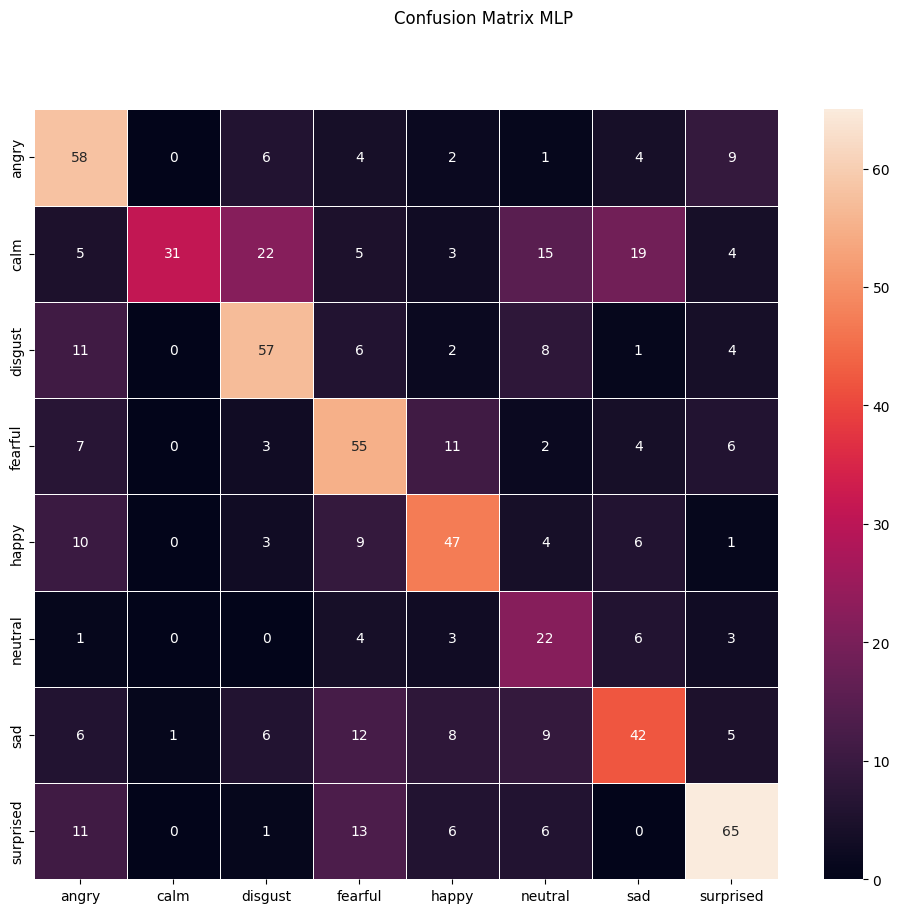

In [35]:
# Evaluate on test data
with torch.no_grad():
    test_pred = model(test_ten)


# Time to print classification report
new_test_pred = torch.FloatTensor([list(test_pred[i]).index(max(test_pred[i]))
     for i in range (len(test_pred))])

print(classification_report(test_y_ten, new_test_pred.cpu()))
print('output tensor after flatten:', test_pred.shape)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = new_test_pred
df['Actual Labels'] = test_y_ten


cm = confusion_matrix(test_y_ten, new_test_pred)
labels=["angry", "calm","disgust","fearful","happy", "neutral", "sad","surprised"]
fig, ax = plt.subplots(figsize=(12,10))        # Sample figsize in inches
fig.suptitle("Confusion Matrix " + "MLP")
f = sns.heatmap(cm,xticklabels=labels,yticklabels=labels, annot=True, linewidths=.5, ax=ax)

Test data below

In [56]:
path1 = r"D:\Program Files\VS Code Projects\elec-301-speech-emotion-classification\test_data"
os.chdir(path1)

MLP_test = []
NUM = []
max_length = 618*20
for path in os.listdir():
    if path.endswith(".wav"):
        NUM.append(str(path[6: 9]))
        feature = get_features(path," ")
        for signal in feature:
            MLP_test.append(feature)

print(len(MLP_test))


315


In [57]:
print(NUM)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142'

In [58]:
# Zero padding the signal
for i in range(len(MLP_test)):
    data = MLP_test[i][0]
    MLP_test[i] = pad_result(data,618*20)

print(MLP_test)

[array([-671.6351, -671.6351, -671.6351, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), array([-845.712 , -872.6959, -891.2575, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), array([-692.1176, -692.1176, -692.1176, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), array([-918.7925, -907.1845, -902.1564, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), array([-598.2599, -576.417 , -565.5287, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), array([-824.4247 , -823.62317, -828.2996 , ...,    0.     ,    0.     ,
          0.     ], dtype=float32), array([-949.90125, -929.27234, -928.1655 , ...,    0.     ,    0.     ,
          0.     ], dtype=float32), array([-802.57404, -792.5362 , -792.0257 , ...,    0.     ,    0.     ,
          0.     ], dtype=float32), array([-733.1564, -732.0873, -732.6966, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), array([-740.90356, -740.90356, -740.90356, ...,    0.     ,    

In [59]:
test_unseen_ten = torch.tensor(MLP_test, dtype=torch.float64)
unseen_test_pred = model(test_unseen_ten)

final_test_pred = torch.FloatTensor([list(unseen_test_pred[i]).index(max(unseen_test_pred[i]))
     for i in range (len(unseen_test_pred))])


res = []
for emo in range(0, len(final_test_pred)):
    if final_test_pred[emo] == 0:
      res.append('angry')
    if final_test_pred[emo] == 1:
      res.append('calm')
    if final_test_pred[emo] == 2:
      res.append('disgust')
    if final_test_pred[emo] == 3:
      res.append('fearful')
    if final_test_pred[emo] == 4:
      res.append('happy')
    if final_test_pred[emo] == 5:
      res.append('neutral')
    if final_test_pred[emo] == 6:
      res.append('sad')
    if final_test_pred[emo] == 7:
      res.append('surprised')
print(res)



['happy', 'calm', 'angry', 'happy', 'angry', 'neutral', 'calm', 'disgust', 'sad', 'sad', 'calm', 'surprised', 'surprised', 'neutral', 'calm', 'happy', 'surprised', 'disgust', 'neutral', 'neutral', 'calm', 'surprised', 'surprised', 'angry', 'disgust', 'calm', 'sad', 'calm', 'calm', 'happy', 'happy', 'happy', 'sad', 'angry', 'sad', 'happy', 'sad', 'happy', 'happy', 'surprised', 'sad', 'neutral', 'happy', 'angry', 'surprised', 'sad', 'sad', 'disgust', 'happy', 'disgust', 'angry', 'happy', 'angry', 'calm', 'disgust', 'fearful', 'disgust', 'fearful', 'neutral', 'surprised', 'fearful', 'angry', 'fearful', 'disgust', 'happy', 'happy', 'sad', 'neutral', 'sad', 'surprised', 'sad', 'angry', 'sad', 'disgust', 'sad', 'angry', 'neutral', 'sad', 'neutral', 'happy', 'calm', 'sad', 'disgust', 'angry', 'angry', 'angry', 'sad', 'surprised', 'angry', 'happy', 'angry', 'fearful', 'sad', 'happy', 'neutral', 'neutral', 'neutral', 'angry', 'surprised', 'happy', 'sad', 'disgust', 'disgust', 'sad', 'happy', 's

In [60]:
res = np.array(res).transpose()
NUM = np.array(NUM).transpose()
sample = np.column_stack([NUM, res])
sort_sample = sample[sample[:, 0].argsort()]
name = []
for item in sort_sample[:,0]:
  item = 'sample'+str(item)
  name.append(item)
name = np.array(name).transpose()
sort_sample[:,0] = name
sort_sample

array([['sample000', 'happy'],
       ['sample001', 'calm'],
       ['sample002', 'angry'],
       ['sample003', 'happy'],
       ['sample004', 'angry'],
       ['sample005', 'neutral'],
       ['sample006', 'calm'],
       ['sample007', 'disgust'],
       ['sample008', 'sad'],
       ['sample009', 'sad'],
       ['sample010', 'calm'],
       ['sample011', 'surprised'],
       ['sample012', 'surprised'],
       ['sample013', 'neutral'],
       ['sample014', 'calm'],
       ['sample015', 'happy'],
       ['sample016', 'surprised'],
       ['sample017', 'disgust'],
       ['sample018', 'neutral'],
       ['sample019', 'neutral'],
       ['sample020', 'calm'],
       ['sample021', 'surprised'],
       ['sample022', 'surprised'],
       ['sample023', 'angry'],
       ['sample024', 'disgust'],
       ['sample025', 'calm'],
       ['sample026', 'sad'],
       ['sample027', 'calm'],
       ['sample028', 'calm'],
       ['sample029', 'happy'],
       ['sample030', 'happy'],
       ['sample031'

In [61]:
import pandas as pd
DF = pd.DataFrame(sort_sample)
DF.to_csv("res.csv")